# Unconformity or Onlap?
This notebook builds synthetic data to classify well logs based on stratal geometry. Specifically it is focused on classifying a well as either having an angular unconformity or onlapping a structural high. There is plenty of work that can be done going forward to build out the training data with more real world examples

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import squareform, pdist

%matplotlib inline

# I dropped off the .drop(column=[0]) section from the end of each section. need to figure out how to get the right size arrays for training and test data

In [2]:
names = [
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "ten",
    "eleven",
    "twelve",
    "thirteen",
    "fourteen",
    "fifteen",
    "sixteen",
]  # this creates dummy names for the formations
number_of_layers = (
    7
)  # this is the number of tops you want in your training data
neighbors = np.random.randint(
    1, 200
)  # if we want to include neighbor data in training
df = pd.DataFrame()

# this section builds some toy data with an angular unconformity
for j in np.arange(-5, 7, 0.1):
    rolling = pd.DataFrame()
    rolling["zero"] = (
        10 * np.sin(1 - np.arange(0, 40, 0.1) / 15.28)
        + np.random.rand(400) / 100
    )
    for i in range(len(names[0:number_of_layers])):
        layer_elevation = 10 * np.sin(
            1 - np.arange(0, 40, 0.1) / 15.28
        ) + np.random.uniform(0, j)
        elevation = np.full(400, j) + np.random.rand(400) / 100
        layer_elevation = (
            np.where(layer_elevation > elevation, elevation, layer_elevation)
            + np.random.rand(400) / 100
        )
        rolling[names[i]] = layer_elevation
    x = np.arange(0, 40, 0.1)
    y = np.random.randint(0, 10, len(x))
    if j % 0.2 > 0.1:
        rolling["ex"] = x * np.cos(-j / 2) - y * np.sin(-j / 2)
        rolling["ey"] = y * np.cos(-j / 2) - x * np.sin(-j / 2)
    else:
        rolling["ex"] = x * np.cos(j / 2) - y * np.sin(j / 2)
        rolling["ey"] = y * np.cos(j / 2) - x * np.sin(j / 2)
    # this loop creates 0 values at random in the data much like you would see in an incomplete tops dataset
    # the range value is the number of entries to set to zero
    for k in range(100):
        rolling.iloc[
            np.random.randint(0, 399),
            np.random.randint(0, number_of_layers - 1),
        ] = 0
    hood = squareform(pdist(rolling.iloc[:, -2:]))
    neighbors = []
    for i in enumerate(hood.argsort()[0:, 1:4]):
        selected = (
            rolling.iloc[hood.argsort()[i[0], 1:4], 0:-2].stack().to_frame().T
        )
        selected.columns = selected.columns.droplevel()
        neighbors.append(selected)
    frame = pd.concat(neighbors, sort=False)
    frame.index = range(len(frame))
    neighborhood = pd.concat(
        [rolling.iloc[:, :-2], frame, rolling.iloc[:, -2:]], axis=1
    )
    df = pd.concat((df, neighborhood))
adec = []
for i in range(len(df)):
    adec.append(df.iloc[i, 1:-2].sort_values()[0:].values)
s3 = pd.DataFrame(adec)
s3.index = df.index.values
angular_thicknesses = s3.diff(axis=1)
# angular_thicknesses = df.T.diff(axis=0).abs().T #calculate formation thicknesses
# neigh = angular_thicknesses.shift(neighbors)
logged = angular_thicknesses.apply(
    np.log
)  # take the log of thicknesses for feature engineering
powered = angular_thicknesses.apply(
    lambda x: x ** 10
)  # calculates the power values of thickness for another feature
angular_thicknesses = (
    pd.concat(
        [angular_thicknesses, logged, powered],
        axis=1,
        join_axes=[angular_thicknesses.index],
    )
    .dropna()
    .replace(-np.inf, 0)
)  # dataframe of angular unconformity fm thicknesses


# now for onlap training data construction
df_onlap = pd.DataFrame()
for j in np.arange(-5, 10, 0.1):
    rolling = pd.DataFrame()
    rolling["zero"] = 10 * np.sin(1 - np.arange(0, 40, 0.1) / 15.28)
    for i in range(len(names[0:number_of_layers])):
        zero = (
            10 * np.sin(1 - np.arange(0, 40, 0.1) / 15.28)
            + np.random.rand(400) / 100
        )
        randomness = np.random.uniform(0, j)
        elevation = np.full(400, j) + np.random.rand(400) / 100
        onlap = np.where(
            np.full(400, randomness) > zero,
            np.full(400, randomness) + np.random.rand(400) / 100,
            zero,
        )
        layer_elevation = (
            np.where(onlap > elevation, elevation, onlap)
            + np.random.rand(400) / 100
        )
        rolling[names[i]] = layer_elevation - np.arange(0, 10, 0.025)
    x = np.arange(0, 40, 0.1)
    y = np.random.randint(0, 10, len(x))
    if j % 0.2 > 0.1:
        rolling["ex"] = x * np.cos(-j / 2) - y * np.sin(-j / 2)
        rolling["ey"] = y * np.cos(-j / 2) - x * np.sin(-j / 2)
    else:
        rolling["ex"] = x * np.cos(j / 2) - y * np.sin(j / 2)
        rolling["ey"] = y * np.cos(j / 2) - x * np.sin(j / 2)
    # this loop creates 0 values at random in the data much like you would see in an incomplete tops dataset
    # the range value is the number of entries to set to zero
    for k in range(100):
        rolling.iloc[
            np.random.randint(0, 399),
            np.random.randint(0, number_of_layers - 1),
        ] = 0
    hood = squareform(pdist(rolling.iloc[:, -2:]))
    neighbors = []
    for i in enumerate(hood.argsort()[0:, 1:4]):
        selected = (
            rolling.iloc[hood.argsort()[i[0], 1:4], 0:-2].stack().to_frame().T
        )
        selected.columns = selected.columns.droplevel()
        neighbors.append(selected)
    frame = pd.concat(neighbors, sort=False)
    frame.index = range(len(frame))
    neighborhood = pd.concat(
        [rolling.iloc[:, :-2], frame, rolling.iloc[:, -2:]], axis=1
    )
    df_onlap = pd.concat((df_onlap, neighborhood))
adec = []
for i in range(len(df_onlap)):
    adec.append(df_onlap.iloc[i, 1:-2].sort_values()[0:].values)
s3 = pd.DataFrame(adec)
s3.index = df_onlap.index.values
onlap_thicknesses = s3.diff(axis=1)
# onlap_thicknesses = df_onlap.T.diff(axis=0).abs().T
# neigh = onlap_thicknesses.shift(neighbors)
logged = onlap_thicknesses.apply(np.log)
powered = onlap_thicknesses.apply(lambda x: x ** 10)
onlap_thicknesses = (
    pd.concat(
        [onlap_thicknesses, logged, powered],
        axis=1,
        join_axes=[onlap_thicknesses.index],
    )
    .dropna()
    .replace(-np.inf, 0)
)

# if you want to create a section with horizontal stratified training data this section will do it

df_horizontal = pd.DataFrame()
for j in np.arange(-5, 10.5, 0.1):
    rolling = pd.DataFrame()
    rolling["zero"] = np.full(400, 0) - np.random.rand(400) / 100
    for i in range(len(names[0:number_of_layers])):
        randomness = np.random.uniform(0, j)
        elevation = np.full(400, j) + np.random.rand(400) / 100
        horiz = np.full(400, randomness)
        layer_elevation = np.where(horiz > elevation, elevation, horiz)
        rolling[names[i]] = layer_elevation - np.arange(0, 10, 0.025)
    x = np.arange(0, 40, 0.1)
    y = np.random.randint(0, 10, len(x))
    if j % 0.2 > 0.1:
        rolling["ex"] = x * np.cos(-j / 2) - y * np.sin(-j / 2)
        rolling["ey"] = y * np.cos(-j / 2) - x * np.sin(-j / 2)
    else:
        rolling["ex"] = x * np.cos(j / 2) - y * np.sin(j / 2)
        rolling["ey"] = y * np.cos(j / 2) - x * np.sin(j / 2)
    for k in range(100):
        rolling.iloc[
            np.random.randint(0, 399),
            np.random.randint(0, number_of_layers - 1),
        ] = 0
    neighbors = []
    for i in enumerate(hood.argsort()[0:, 1:4]):
        selected = (
            rolling.iloc[hood.argsort()[i[0], 1:4], 0:-2].stack().to_frame().T
        )
        selected.columns = selected.columns.droplevel()
        neighbors.append(selected)
    frame = pd.concat(neighbors, sort=False)
    frame.index = range(len(frame))
    neighborhood = pd.concat(
        [rolling.iloc[:, :-2], frame, rolling.iloc[:, -2:]], axis=1
    )
    df_horizontal = pd.concat((df_horizontal, neighborhood))
adec = []
for i in range(len(df_horizontal)):
    adec.append(df_horizontal.iloc[i, 1:-2].sort_values()[0:].values)
s3 = pd.DataFrame(adec)
s3.index = df_horizontal.index.values
horizontal_thicknesses = s3.diff(axis=1)
# horizontal_thicknesses = df_horizontal.T.diff(axis=0).abs().T
# neigh = horizontal_thicknesses.shift(neighbors)
logged = horizontal_thicknesses.apply(np.log)
powered = horizontal_thicknesses.apply(lambda x: x ** 10)
horizontal_thicknesses = (
    pd.concat(
        [horizontal_thicknesses, logged, powered],
        axis=1,
        join_axes=[horizontal_thicknesses.index],
    )
    .dropna()
    .replace(-np.inf, 0)
)

# NORMALIZING THE DATA
# normalize the data from 0 to 1
normalized_df = (angular_thicknesses - angular_thicknesses.min()) / (
    angular_thicknesses.max() - angular_thicknesses.min()
).replace(0, 0.00001)
normalized_locations = (df - df.min()) / (df.max() - df.min())
x = normalized_locations.ex.values
y = normalized_locations.ey.values
normalized_df["x"] = x
normalized_df["y"] = y


normalized_dfo = (onlap_thicknesses - onlap_thicknesses.min()) / (
    onlap_thicknesses.max() - onlap_thicknesses.min()
).replace(0, 0.00001)
normalized_locationso = (df_onlap - df_onlap.min()) / (
    df_onlap.max() - df_onlap.min()
)
x = normalized_locationso.ex
y = normalized_locationso.ey
normalized_dfo["x"] = x
normalized_dfo["y"] = y


normalized_dfh = (horizontal_thicknesses - horizontal_thicknesses.min()) / (
    horizontal_thicknesses.max() - horizontal_thicknesses.min()
).replace(0, 0.00001)
normalized_locationsh = (df_horizontal - df_horizontal.min()) / (
    df_horizontal.max() - df_horizontal.min()
)
x = normalized_locationsh.ex
y = normalized_locationsh.ey
normalized_dfh["x"] = x
normalized_dfh["y"] = y


# now assign classes to the datasets, 1 is onlap, 0 is angular unconformity
normalized_dfa["class"] = 0
normalized_dfo["class"] = 1
normalized_dfh["class"] = 2


# merge into new dataset
dataset = pd.concat(
    (normalized_df, normalized_dfo, normalized_dfh)
)  # , normalized_dfh))

NameError: name 'normalized_dfa' is not defined

In [ ]:
df.iloc[40000:40400, 1:-2].plot(
    legend=False, figsize=(20, 10), cmap="copper"
).set_aspect(6)
df_onlap.iloc[40000:40400, 1:-2].plot(
    legend=False, figsize=(20, 10), cmap="copper"
).set_aspect(6)
df_horizontal.iloc[40000:40400, 1:-2].plot(
    legend=False, figsize=(20, 10), cmap="copper"
).set_aspect(6)

In [7]:
from sklearn.model_selection import train_test_split

# next let's split our toy data into training and test sets, choose how much with test_size of the data becomes the test set
X_train, X_test, y_train, y_test = train_test_split(
    dataset.iloc[0:, 0:-1].values,
    dataset.iloc[0:, -1].values,
    test_size=0.5,
    random_state=86,
)

In [8]:
from keras.utils import to_categorical

y_train_encoded = to_categorical(
    y_train
)  # this converts the target variable to one-hot encoding
y_test_encoded = to_categorical(
    y_test
)  # same with the test data conversion to one-hot encoding

Using TensorFlow backend.


In [9]:
# Import keras and some layers, we are going to build a network with two dense layers and a dropout layer
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [10]:
# this is the network, we initialize with a dense layer and a relu activation
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dropout(0.1))  # dropout to avoid overfitting
model.add(
    Dense(1000, kernel_initializer="random_uniform", activation="sigmoid")
)
model.add(Dropout(0.2))
model.add(
    Dense(3, kernel_initializer="random_uniform", activation="softmax")
)  # and another dense layer with sigmoid activation

In [11]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="nadam",
    metrics=["categorical_accuracy"],
)
# builds the model, with categorical crossentropy for our loss function, optimizing using nadam, and using categorical accuracy
# as our accuracy metric

In [12]:
from keras.callbacks import TensorBoard

tbCallBack = TensorBoard(
    log_dir="./Graph", histogram_freq=10, write_graph=True, write_images=True
)

In [13]:
model.fit(
    X_train,
    y_train_encoded,
    epochs=2,
    batch_size=32,
    verbose=1,
    validation_split=0.3,
    callbacks=[tbCallBack],
)  # Fitting the model for 60 epochs and batch size of 32

Train on 59499 samples, validate on 25501 samples
Epoch 1/2
59499/59499 [==============================] - 5s 91us/step - loss: nan - categorical_accuracy: 0.2823 - val_loss: nan - val_categorical_accuracy: 0.2844


InvalidArgumentError: Nan in summary histogram for: dense_2/kernel_0
	 [[Node: dense_2/kernel_0 = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_2/kernel_0/tag, ArithmeticOptimizer/RemoveIdempotent_Squeeze_2)]]

Caused by op 'dense_2/kernel_0', defined at:
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\ioloop.py", line 759, in _run_callback
    ret = callback()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-fa647aa5c1d1>", line 1, in <module>
    model.fit(X_train, y_train_encoded, epochs=2, batch_size=32, verbose=1, validation_split=0.3, callbacks=[tbCallBack]) #Fitting the model for 60 epochs and batch size of 32
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training_arrays.py", line 117, in fit_loop
    callbacks.set_model(callback_model)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks.py", line 54, in set_model
    callback.set_model(model)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks.py", line 796, in set_model
    tf.summary.histogram(mapped_weight_name, weight)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\summary\summary.py", line 187, in histogram
    tag=tag, values=values, name=scope)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gen_logging_ops.py", line 309, in histogram_summary
    "HistogramSummary", tag=tag, values=values, name=name)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Nan in summary histogram for: dense_2/kernel_0
	 [[Node: dense_2/kernel_0 = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_2/kernel_0/tag, ArithmeticOptimizer/RemoveIdempotent_Squeeze_2)]]


In [ ]:
score = model.evaluate(
    X_test, y_test_encoded
)  # tests the model on the test data
score

In [ ]:
# model.save('.\onlap_model_3_surfaces.h5')

In [ ]:
preds = model.predict(
    X_test
)  # creates predictions on the test data that we can use
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, np.argmax(preds, axis=1), normalize=True
)  # let's visualize the predictions

In [ ]:
# from keras.models import load_model
# model2 = load_model('onlap_model.h5')
# preds2 = model2.predict(X_test)

In [ ]:
# import scikitplot as skplt
# skplt.metrics.plot_confusion_matrix(y_test, np.argmax(preds2, axis=1), normalize=True) #let's visualize the predictions

# Real World Data

In [ ]:
# from keras.models import load_model
# model = load_model('onlap_model_3_surfaces.h5')

In [ ]:
# let's import some real world data from southwestern Wyoming
# this is from the Ro`ck Springs Uplift in Wyoming and has been interpreted as an angular unconformity
tops_api = pd.read_csv(r"D:\jupyter\EarlyWSGS\ftunion.csv").fillna(
    0
)  # this file is available in the unconformity or onlap folder in the repo
# tops = tops_api[['Kl', 'Kll', 'Klz', 'Kfh']]
tops = tops_api[["Tfu", "Tfob", "Tfc", "Kl", "Kll", "Klz", "Kfh", "x", "y"]]

In [ ]:
hood = squareform(pdist(tops.iloc[:, -2:]))
neighbors = []
for i in enumerate(hood.argsort()[0:, 1:4]):
    selected = tops.iloc[hood.argsort()[i[0], 1:4], 0:-2].stack().to_frame().T
    selected.columns = selected.columns.droplevel()
    neighbors.append(selected)
frame = pd.concat(neighbors, sort=False)
frame.index = range(len(frame))
neighborhood = pd.concat([tops.iloc[:, :-2], frame, tops.iloc[:, -2:]], axis=1)

In [ ]:
# clean up the real world data, take the tops from depth to thickness for each formation and get rid of negative thicknesses
tops2 = neighborhood.diff(axis=1, periods=-1).iloc[:, :-2] * -1
tops2[tops2 < 0] = 0
tops2[tops2 > 2000] = 0

In [ ]:
# neigh = tops2.shift(1)
logged = tops2.apply(
    np.log
)  # creating the same features that we built in the training data
powered = tops2.apply(
    lambda x: x ** 10
)  # creating the same features that we built in the training data
tops3 = (
    pd.concat([tops2, logged, powered], axis=1, join_axes=[tops2.index])
    .fillna(0)
    .replace(-np.inf, 0)
)
tops3["x"] = tops_api.x
tops3["y"] = tops_api.y

In [ ]:
normalized_tops3 = (tops3 - tops3.min()) / (tops3.max() - tops3.min()).replace(
    0, 0.00001
)  # normalize the data from 0 to 1
real_data = normalized_tops3.values

In [ ]:
normalized_dfo.columns.shape

In [ ]:
tops3.columns.shape

In [41]:
well_preds = model.predict(real_data)  # make some predictions

ValueError: Error when checking input: expected dense_1_input to have shape (92,) but got array with shape (90,)

In [ ]:
predictions = np.argmax(
    well_preds, axis=1
)  # convert them to our binary classification

In [ ]:
plt.hist(
    predictions, label=["Angular Unconformity", "Onlap"]
)  # visualize the predictions as a histogram, we are expecting all the wells to be classified as '0'

In [20]:
tops_api["predictions"] = predictions

In [21]:
well_locs = pd.read_csv(
    r"D:\jupyter\EarlyWSGS\well_locations.csv", encoding="ISO-8859-1"
)

In [22]:
merged = pd.merge(tops_api, well_locs, on="API")

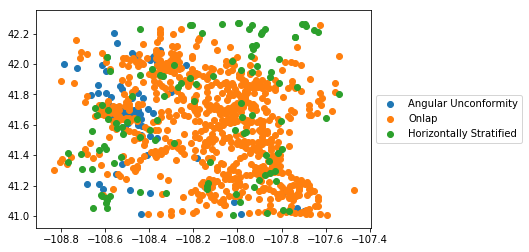

In [23]:
plt.scatter(
    merged[merged["predictions"] == 0].LON,
    merged[merged["predictions"] == 0].LAT,
    label="Angular Unconformity",
)
plt.scatter(
    merged[merged["predictions"] == 1].LON,
    merged[merged["predictions"] == 1].LAT,
    label="Onlap",
)
plt.scatter(
    merged[merged["predictions"] == 2].LON,
    merged[merged["predictions"] == 2].LAT,
    label="Horizontally Stratified",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))